In [1]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# IO
import netCDF4 as nc

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
from torch.optim.lr_scheduler import PolynomialLR, CosineAnnealingWarmRestarts

# PyTorch-Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split

# Wandb
import wandb

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

In [4]:
data = nc.Dataset("data/kepler.nc").variables
keys = data.keys()
vals = data.values()

data_dict = {}

for k, v in zip(keys, vals):
    data_dict[k] = np.array(v[:])

df = pd.DataFrame(data_dict)

In [5]:
df

,t,x,y,vx,vy,E,L,g
0,0.000000,2.919807,-2.386163,-0.582427,0.015088,-0.095470,-1.345712,0
1,0.009153,2.914474,-2.386024,-0.582926,0.015496,-0.095470,-1.345712,0
2,0.018306,2.909136,-2.385880,-0.583426,0.015906,-0.095470,-1.345712,0
3,0.027459,2.903793,-2.385732,-0.583926,0.016316,-0.095470,-1.345712,0
4,0.036612,2.898447,-2.385581,-0.584427,0.016728,-0.095470,-1.345712,0
...,...,...,...,...,...,...,...,...
50003,90.252157,3.218096,-3.962491,0.411937,0.171525,-0.096343,2.184281,4
50004,90.261185,3.221815,-3.960941,0.411718,0.171794,-0.096343,2.184281,4
50005,90.270214,3.225531,-3.959389,0.411500,0.172063,-0.096343,2.184281,4
50006,90.279243,3.229245,-3.957834,0.411281,0.172331,-0.096343,2.184281,4


In [6]:
groups = np.unique(df.g)
groups

array([0, 1, 2, 3, 4], dtype=uint64)

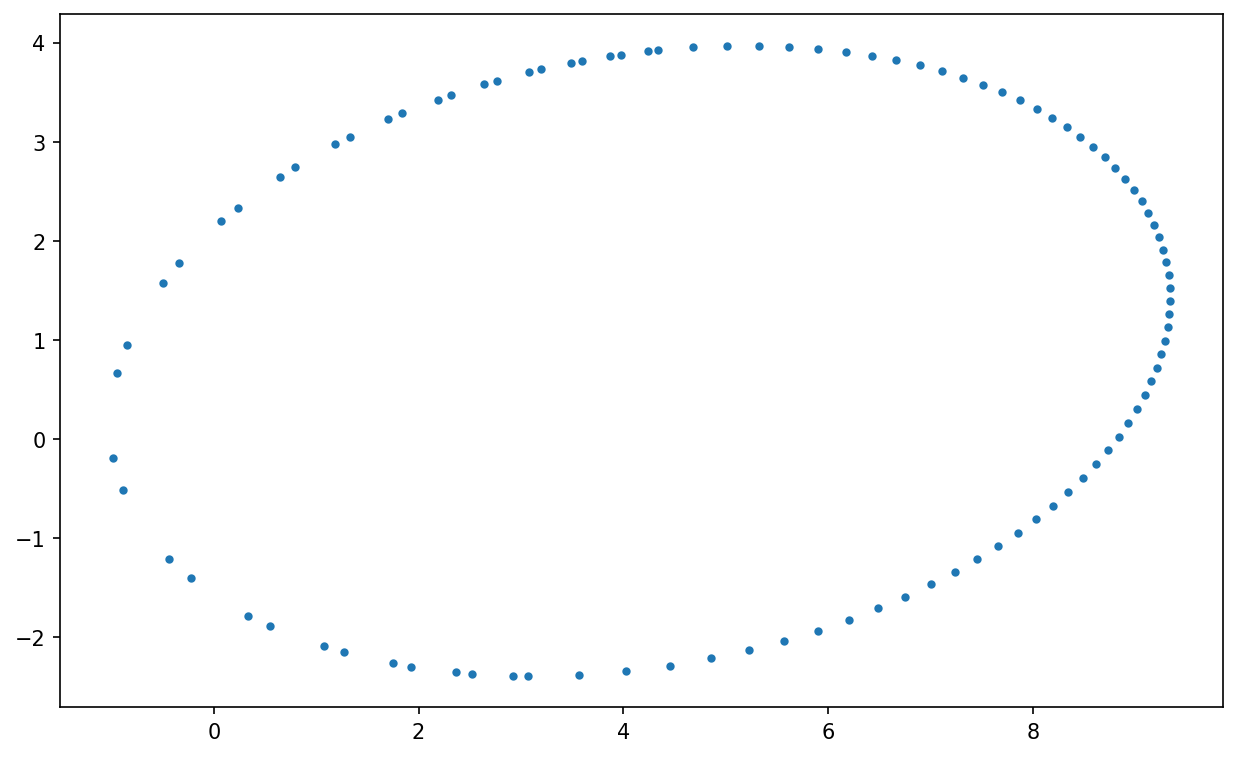

In [7]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(df.x[df.g==0][::100], df.y[df.g==0][::100], '.')
plt.show()

In [8]:
class Kepler2D(Dataset):
    def __init__(self, df):
        X = df.to_numpy()
        self.X = torch.tensor(X[:, 1:-3], dtype=torch.float32)
        self.g = torch.tensor(X[:, -1:], dtype=torch.uint8).reshape((-1,1))
        self.L = torch.tensor(X[:, -2:-1], dtype=torch.float32).reshape((-1,1))
        self.E = torch.tensor(X[:, -3:-2], dtype=torch.float32).reshape((-1,1))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.g[idx], self.L[idx], self.E[idx]

In [9]:
ds = Kepler2D(df)

In [10]:
len(ds)

50008

In [11]:
ds[0]

(tensor([ 2.9198, -2.3862, -0.5824,  0.0151]),
 tensor([0], dtype=torch.uint8),
 tensor([-1.3457]),
 tensor([-0.0955]))

In [12]:
class ASNet(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        self.h1_n  = hparams["hidden_layer_1_nodes"]
        self.h1_d  = hparams["hidden_layer_1_depth"]
        self.h2_n  = hparams["hidden_layer_2_nodes"]
        self.h2_d  = hparams["hidden_layer_2_depth"]
        self.lr    = hparams["learning_rate"]
        self.batch = hparams["batch_size"]
        self.epoch = hparams["epoch"]
#         self.gamma = hparams["gamma"]
        
        E_vec = torch.tensor(hparams["E_init"], dtype=torch.float32)
        L_vec = torch.tensor(hparams["L_init"], dtype=torch.float32)
        
        self.E = nn.Parameter(E_vec, requires_grad=True)
        self.L = nn.Parameter(L_vec, requires_grad=True)
        self.group = len(self.E)
        
        assert(self.group == len(self.L))
        
        h1 = [
            nn.Linear(4, self.h1_n),
            nn.GELU(),
            nn.BatchNorm1d(self.h1_n)
        ]
        
        for i in range(self.h1_d):
            h1.extend([
                nn.Linear(self.h1_n, self.h1_n),
                nn.GELU(),
                nn.BatchNorm1d(self.h1_n)
            ])
            
        h1.append(nn.Linear(self.h1_n, 2)) # E, L
        
        h2 = [
            nn.Linear(3, self.h2_n),
            nn.GELU(),
            nn.BatchNorm1d(self.h2_n)
        ]
        
        for i in range(self.h2_d):
            h2.extend([
                nn.Linear(self.h2_n, self.h2_n),
                nn.GELU(),
                nn.BatchNorm1d(self.h2_n)
            ])
        
        h2.append(nn.Linear(self.h2_n, 2))
        
        self.net1 = nn.Sequential(*h1)
        self.net2 = nn.Sequential(*h2)
        
        self.save_hyperparameters(hparams)
        
        self.ds = None
        
    def _forward_features(self, x):
        x = self.net1(x)
        return x
    
    def forward(self, x):
        X, _, _, _ = x
        th = torch.atan(X[:,1:2] / X[:,0:1])
        x = self._forward_features(x)
        x = torch.column_stack([x, th])
        return self.net2(x)
    
    def training_step(self, batch, batch_idx):
        # Decompose Batch
        X, g, _, _ = batch
        x  = X[:,0:1]
        y  = X[:,1:2]
        vx = X[:,2:3]
        vy = X[:,3:4]
        th = torch.atan(y/x)
        
        # Decompose First Output
        EL   = self._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])
        
        # Obtain group indices
        g_ics_vec = [g == i for i in range(self.group)]
        
        E_aux = torch.ones_like(E)
        L_aux = torch.ones_like(L)
        
        for (g_ics, E_a, L_a) in zip(g_ics_vec, self.E, self.L):
            E_aux[g_ics[:,0]] *= E_a
            L_aux[g_ics[:,0]] *= L_a
        
        # Reconstruct position
        RV     = self.net2(ELTh)
        R      = RV[:,0:1]
        V      = RV[:,1:2]
        x_hat  = R * torch.cos(th)
        y_hat  = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        loss_x  = ((x - x_hat)**2).mean()
        loss_y  = ((y - y_hat)**2).mean()
        loss_vx = ((vx-vx_hat)**2).mean()
        loss_vy = ((vy-vy_hat)**2).mean()
        loss_E = ((E - E_aux)**2).mean()
        loss_L = ((L - L_aux)**2).mean()
        
        loss = loss_x + loss_y + loss_E + loss_L + loss_vx + loss_vy
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Decompose Batch
        X, g, _, _ = batch
        x  = X[:,0:1]
        y  = X[:,1:2]
        vx = X[:,2:3]
        vy = X[:,3:4]
        th = torch.atan(y/x)
        
        # Decompose First Output
        EL   = self._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])
        
        # Obtain group indices
        g_ics_vec = [g == i for i in range(self.group)]
        
        E_aux = torch.ones_like(E)
        L_aux = torch.ones_like(L)
        
        for (g_ics, E_a, L_a) in zip(g_ics_vec, self.E, self.L):
            E_aux[g_ics[:,0]] *= E_a
            L_aux[g_ics[:,0]] *= L_a
        
        # Reconstruct position
        RV     = self.net2(ELTh)
        R      = RV[:,0:1]
        V      = RV[:,1:2]
        x_hat  = R * torch.cos(th)
        y_hat  = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        loss_x  = ((x - x_hat)**2).mean()
        loss_y  = ((y - y_hat)**2).mean()
        loss_vx = ((vx-vx_hat)**2).mean()
        loss_vy = ((vy-vy_hat)**2).mean()
        loss_E = ((E - E_aux)**2).mean()
        loss_L = ((L - L_aux)**2).mean()
        
        loss = loss_x + loss_y + loss_E + loss_L + loss_vx + loss_vy
        
        self.log('val_loss', loss)
        self.log('loss_x', loss_x)
        self.log('loss_y', loss_y)
        self.log('loss_E', loss_E)
        self.log('loss_L', loss_L)
        
        for i, (g_ics, E_a, L_a) in enumerate(zip(g_ics_vec, self.E, self.L)):
            E_mean = E[g_ics[:,0]].mean()
            L_mean = L[g_ics[:,0]].mean()

            self.log(f"E_{i}", E_mean)
            self.log(f"L_{i}", L_mean)
            self.log(f"E_a_{i}", E_a)
            self.log(f"L_a_{i}", L_a)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": CosineAnnealingWarmRestarts(
                optimizer,
                T_0=50,
                T_mult=2,
                eta_min=0
                
            )
        }
    
    def prepare_data(self):
        self.ds = ds
        self.N = len(self.ds)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch)

In [13]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [14]:
hparams = {
    "hidden_layer_1_nodes": 32,
    "hidden_layer_1_depth": 3,
    "hidden_layer_2_nodes": 256,
    "hidden_layer_2_depth": 5,
    "learning_rate": 1e-4,
    "batch_size": BATCH_SIZE,
    "E_init": [-0.5, -0.5, -0.5, -0.5, -0.5],
    "L_init": [0.5, 0.5, 0.5, 0.5, 0.5],
    "epoch": 300
}

In [15]:
model = ASNet(
    hparams=hparams
)

In [16]:
model

ASNet(
  (net1): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): GELU(approximate='none')
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): GELU(approximate='none')
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=

In [17]:
wandb_logger = WandbLogger(
    project='Auxiliary_Symmetry',
#     log_model="all"
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams["epoch"],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
#         EarlyStopping(monitor="val_loss", mode="min", patience=20),
#         ModelCheckpoint(monitor="val_loss", mode="min"),
        StochasticWeightAveraging(swa_lrs=1e-5)
    ]
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


/home/kavis/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net1 | Sequential | 3.6 K 
1 | net2 | Sequential | 333 K 
------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.349     Total estimated model params size (MB)
/home/kavis/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kavis/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

In [19]:
trainer.save_checkpoint('AuxSym_atan_0.pth')
wandb.save('AuxSym_atan_0.pth')

['./wandb/run-20230220_110114-2k9nj51f/files/AuxSym_atan_0.pth']

In [20]:
wandb.finish()

E_0,█▆▃▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃
E_1,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
E_2,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
E_3,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
E_4,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
E_a_0,▆██▅▄▃▃▁▁▂▂▂▃▃▃▃▃▃▃▄▃▃▃▄▃▄▄▄▄▄▄▄▅▄▄▄▅▅▅▅
E_a_1,▁▄▇████▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▆▅▅▅▅▅▅
E_a_2,▁▂▄▅▆▆▆████▇▇▇▇▇▆▆▆▆▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅
E_a_3,▁▃▆▇▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆
E_a_4,▁▅██▆▆▅▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄
L_0,▁▃▆▇████████████████████████████████████


## Analysis

In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

./Auxiliary_Symmetry/2k9nj51f/checkpoints/epoch=300-step=41237.ckpt


In [22]:
with open("best_model_path.txt", 'w') as f:
    f.write(best_model_path)

In [23]:
model = ASNet.load_from_checkpoint(best_model_path)
model

ASNet(
  (net1): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): GELU(approximate='none')
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): GELU(approximate='none')
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=

In [24]:
model.eval()
dl_total = DataLoader(ds, batch_size=BATCH_SIZE)

In [25]:
def decoder(model, dl):
    dl_iter = iter(dl)
    X_init, g, _, _ = next(dl_iter)
    g_ics_vec = [g == i for i in range(model.group)]
    th = torch.atan(X_init[:,1:2] / X_init[:,0:1])
    
    EL   = model._forward_features(X_init)
    E    = EL[:,0:1]
    L    = EL[:,1:2]
    ELTh = torch.column_stack([E, L, th])
    
    RV = model.net2(ELTh)
    R = RV[:,0:1]
    V = RV[:,1:2]
    x_hat = R * torch.cos(th)
    y_hat = R * torch.sin(th)
    vx_hat = -V * torch.sin(th)
    vy_hat = V * torch.cos(th)
    
    output_vec = [
        torch.column_stack([
            x_hat[g_ics[:,0]],
            y_hat[g_ics[:,0]],
            vx_hat[g_ics[:,0]],
            vy_hat[g_ics[:,0]],
            E[g_ics[:,0]],
            L[g_ics[:,0]]
        ]) for g_ics in g_ics_vec
    ]
    
    for data in dl_iter:
        X, g, _, _ = data
        g_ics_vec = [g == i for i in range(model.group)]
        th = torch.atan(X[:,1:2] / X[:,0:1])
    
        EL   = model._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])

        RV = model.net2(ELTh)
        R = RV[:,0:1]
        V = RV[:,1:2]
        x_hat = R * torch.cos(th)
        y_hat = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        output_vec = [
            torch.concat([
                a,
                torch.column_stack([
                    x_hat[g_ics[:,0]],
                    y_hat[g_ics[:,0]],
                    vx_hat[g_ics[:,0]],
                    vy_hat[g_ics[:,0]],
                    E[g_ics[:,0]],
                    L[g_ics[:,0]]
                ])
            ]) for (a, g_ics) in zip(output_vec, g_ics_vec)
        ]
    return output_vec

In [26]:
output_vec = decoder(model, dl_total)

In [27]:
[print(output.shape) for output in output_vec];

torch.Size([10002, 6])
torch.Size([10002, 6])
torch.Size([10002, 6])
torch.Size([10001, 6])
torch.Size([10001, 6])


In [28]:
X0 = output_vec[0].detach().numpy()

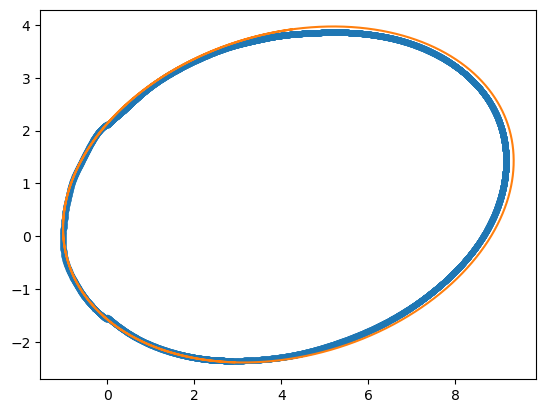

In [29]:
x_hat = X0[:,0]
y_hat = X0[:,1]

plt.plot(x_hat, y_hat, '.')
plt.plot(df.x[df.g==0], df.y[df.g==0])
plt.show()

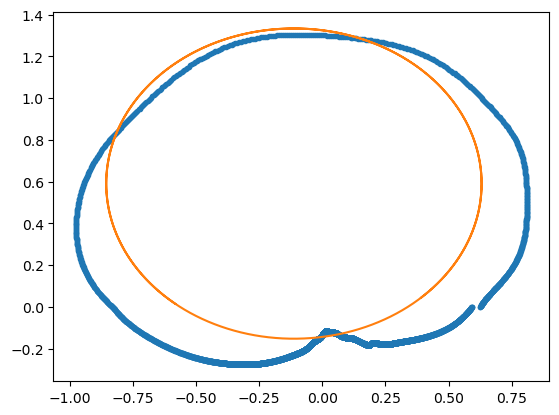

In [30]:
vx_hat = X0[:,2]
vy_hat = X0[:,3]

plt.plot(vx_hat, vy_hat, '.')
plt.plot(df.vx[df.g==0], df.vy[df.g==0])
plt.show()

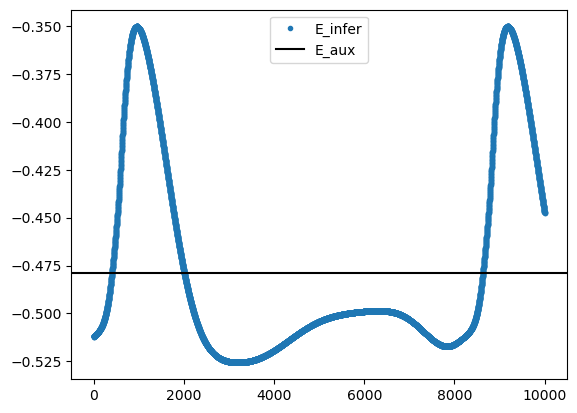

In [31]:
plt.plot(X0[:,4], '.', label='E_infer')
plt.axhline(model.E[0].detach().numpy(), color='k', label='E_aux')
plt.legend()
plt.show()

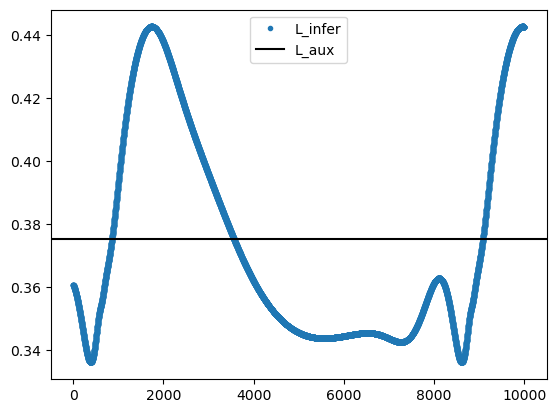

In [32]:
plt.plot(X0[:,5], '.', label='L_infer')
plt.axhline(model.L[0].detach().cpu(), color='k', label='L_aux')
plt.legend()
plt.show()